## Connect google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [3]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))


Your runtime has 13.7 gigabytes of available RAM



## Loading data from drive to the server

In [4]:
!unzip '/content/drive/My Drive/Thesis_Colab/VOC_197GB_2012.zip'

Streaming output truncated to the last 5000 lines.
  inflating: __MACOSX/VOC2012/JPEGImages/._2010_006146.jpg  
  inflating: VOC2012/JPEGImages/2010_000537.jpg  
  inflating: __MACOSX/VOC2012/JPEGImages/._2010_000537.jpg  
  inflating: VOC2012/JPEGImages/2009_002697.jpg  
  inflating: __MACOSX/VOC2012/JPEGImages/._2009_002697.jpg  
  inflating: VOC2012/JPEGImages/2010_004751.jpg  
  inflating: __MACOSX/VOC2012/JPEGImages/._2010_004751.jpg  
  inflating: VOC2012/JPEGImages/2011_005027.jpg  
  inflating: __MACOSX/VOC2012/JPEGImages/._2011_005027.jpg  
  inflating: VOC2012/JPEGImages/2011_002748.jpg  
  inflating: __MACOSX/VOC2012/JPEGImages/._2011_002748.jpg  
  inflating: VOC2012/JPEGImages/2010_004989.jpg  
  inflating: __MACOSX/VOC2012/JPEGImages/._2010_004989.jpg  
  inflating: VOC2012/JPEGImages/2008_006099.jpg  
  inflating: __MACOSX/VOC2012/JPEGImages/._2008_006099.jpg  
  inflating: VOC2012/JPEGImages/2010_002320.jpg  
  inflating: __MACOSX/VOC2012/JPEGImages/._2010_002320.jpg  


## Installing required libraries

In [5]:
!pip install d2l
!pip install mxnet

     |████████████████████████████████| 61kB 3.7MB/s 
     |████████████████████████████████| 55.0MB 87kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


## Importing the required libraries

In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.pyplot import imshow
%matplotlib inline
from PIL import Image

import numpy as np
import os
import glob

import sys
import json
import datetime
import skimage.draw
from bs4 import BeautifulSoup as bs
import cv2
import imgaug

# dive into deep learning library
from d2l import mxnet as d2l
# apace deep learning library mxnet
from mxnet import gluon, image, np, npx

npx.set_np()

## Checking Structure

In [8]:
os.listdir(os.getcwd() + "/VOC2012")

['JPEGImages',
 'SegmentationClass',
 'Annotations',
 'ImageSets',
 '.DS_Store',
 'SegmentationObject']

In [9]:
print('SegmentationObject:', len(os.listdir(os.getcwd() + "/VOC2012/SegmentationObject")))

SegmentationObject: 2913


In [10]:
print('JPEGImages:', len(os.listdir(os.getcwd() + "/VOC2012/JPEGImages")))

JPEGImages: 17125


In [11]:
print('SegmentationClass:', len(os.listdir(os.getcwd() + "/VOC2012/SegmentationClass")))

SegmentationClass: 2913


In [12]:
print('ImageSets:', len(os.listdir(os.getcwd() + "/VOC2012/ImageSets")))

ImageSets: 5


In [13]:
print('Annotations:', len(os.listdir(os.getcwd() + "/VOC2012/Annotations")))

Annotations: 17125


## Plotting one image

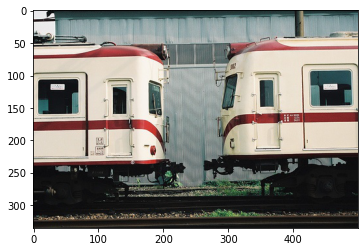

In [14]:
my_image = Image.open("/content/VOC2012/JPEGImages/2007_000042.jpg")
plt.imshow(my_image)
plt.show()

## Fetching Original and Segmented classes images

In [16]:
voc2012_dir = os.getcwd() + "/VOC2012"

# method to fetch the original Jpeg images and segmented classes PNG images
def readImages(voc2012_dir, is_train=True):
    #Read all feature and label images
    txt_fname = os.path.join(voc2012_dir, 'ImageSets', 'Segmentation',
                             'train.txt' if is_train else 'val.txt')
    with open(txt_fname, 'r') as f:
        images = f.read().split()
    jpegImages, segmentationClass, segmentationObject = [], [], []
    for i, fname in enumerate(images):
        jpegImages.append(image.imread(os.path.join(
            voc2012_dir, 'JPEGImages', f'{fname}.jpg')))
        segmentationClass.append(image.imread(os.path.join(
            voc2012_dir, 'SegmentationClass', f'{fname}.png')))
        segmentationObject.append(image.imread(os.path.join(
            voc2012_dir, 'SegmentationObject', f'{fname}.png')))
    return jpegImages, segmentationClass, segmentationObject

train_jpegImages, train_segmentationClass, train_segmentationObject = readImages(voc2012_dir, True)

## Plotting the original vs segmented images 

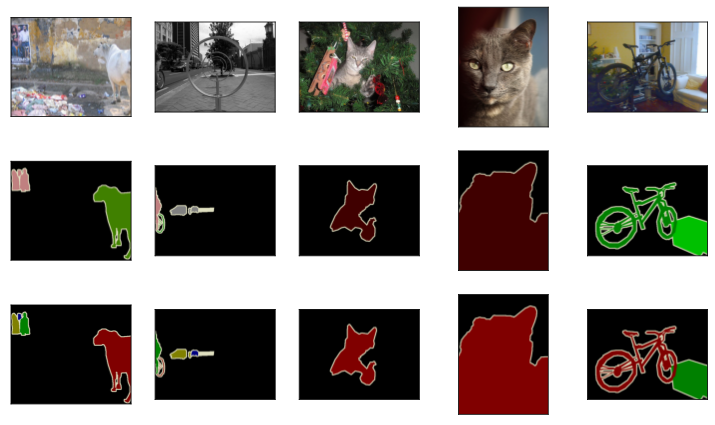

In [17]:
d2l.set_figsize(figsize=(5.5, 2.5))
#plt.figure(figsize=(20,10)) 
n = 5
imgs = train_jpegImages[15:n+15] + train_segmentationClass[15:n+15] + train_segmentationObject[15:n+15]
d2l.show_images(imgs, 3, n, scale=2.5);

In [ ]:
# NormalImage = glob.glob("/content/VOC2012/VOC2012/JPEGImages/*.jpg") #path of normal images
# AnnotatedImage = glob.glob("/content/VOC2012/VOC2012/Annotations/*.xml") #path annotated xmls

In [ ]:
# #function for getting the data
# def get_data(NI,AI):

#   '''
#   Here we have initialised two lists, converting the normal images and the annotated (labels) images
#   appending them to ‘normal_image’ and ‘annotated_image’ respectively and returning the list.
  
#   The imported data is also being converted to numpy array 
#   As well as also showing image of some of the imported data
#   '''

#   normal_image = []
#   annotated_image = []
#   normal_image_np = []
#   annotated_image_np = []

#   for image, mask in zip(sorted(NI), sorted(AI)):
#     normal_image.append(image)
#     annotated_image.append(mask)
#     normal_image_np.append(np.array(Image.open(image)))
#     annotated_image_np.append(np.array(Image.open(mask))) 

#   #sorting the data 
#   annotated_image.sort()
#   normal_image.sort()

#   normal_image_ns = np.asarray(normal_image_np)
#   annotated_image_ns = np.asarray(annotated_image_np)

#   x = np.asarray(normal_image_ns, dtype=np.float32)/255 #  Normalization of data
#   y = np.asarray(annotated_image_ns, dtype=np.float32)/255  #  Normalization of data 

#   # x = x.reshape(x.shape[0], x.shape[1], x.shape[2], 4)
#   # y = y.reshape(y.shape[0], y.shape[1], y.shape[2], 4) # mode=P that means it is palettised
  
#   #plotting the dataset
#   figsize=(25,5)
#   fig, ax = plt.subplots(nrows=2, ncols=5, figsize=figsize)

#   #Normal Image
#   for count,ele in enumerate(normal_image[0:5]): 
    
#     #plotting the tiusse image
#     img = mpimg.imread(ele)
#     ax[0,count].set(title = ele.split('/')[-1])
#     ax[0,count].imshow(img)
  
#   #Annotated Image
#   for count,ele in enumerate(annotated_image[0:5]): 
#     #plotting the tiusse image
#     img = mpimg.imread(ele)
#     ax[1,count].set(title = ele.split('/')[-1])
#     ax[1,count].imshow(img)
  
#   fig.tight_layout() 
  
#   return normal_image,annotated_image,x,y

In [ ]:
# #get data 
# normal_image,annotated_image,x,y = get_data(NormalImage,AnnotatedImage)

## Mapping the colors with the classes

START - Based on reference: https://d2l.ai/chapter_computer-vision/semantic-segmentation-and-dataset.html

In [ ]:
VOC_COLORMAP = [[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
                [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
                [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
                [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
                [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
                [0, 64, 128]]

VOC_CLASSES = ['background', 'aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
               'diningtable', 'dog', 'horse', 'motorbike', 'person',
               'potted plant', 'sheep', 'sofa', 'train', 'tv/monitor']

In [ ]:
def build_colormap2label():
    """Build an RGB color to label mapping for segmentation."""
    colormap2label = np.zeros(256 ** 3)
    for i, colormap in enumerate(VOC_COLORMAP):
        colormap2label[(colormap[0]*256 + colormap[1])*256 + colormap[2]] = i
    return colormap2label

def voc_label_indices(colormap, colormap2label):
    """Map an RGB color to a label."""
    colormap = colormap.astype(np.int32)
    idx = ((colormap[:, :, 0] * 256 + colormap[:, :, 1]) * 256
           + colormap[:, :, 2])
    return colormap2label[idx]

In [ ]:
y = voc_label_indices(train_segmentationClass[2], build_colormap2label())
y[105:115, 130:140], VOC_CLASSES[9]

(array([[9., 9., 9., 9., 9., 9., 9., 9., 9., 9.],
        [9., 9., 9., 9., 9., 9., 9., 9., 9., 9.],
        [9., 9., 9., 9., 9., 9., 9., 9., 9., 9.],
        [9., 9., 9., 9., 9., 9., 9., 9., 9., 9.],
        [9., 9., 9., 9., 9., 9., 9., 9., 9., 9.],
        [9., 9., 9., 9., 9., 9., 9., 9., 9., 9.],
        [9., 9., 9., 9., 9., 9., 9., 9., 9., 9.],
        [9., 9., 9., 9., 9., 9., 9., 9., 9., 9.],
        [9., 9., 9., 9., 9., 9., 9., 9., 9., 9.],
        [9., 9., 9., 9., 9., 9., 9., 9., 9., 9.]]), 'chair')

END - Based on reference: https://d2l.ai/chapter_computer-vision/semantic-segmentation-and-dataset.html

## Helping methods

In [ ]:
def loadVoc2012(baseDir, trainvalType, vocYear='2012'):
    """Load a voc_year of the VOC dataset.
        baseDir: The root directory of the VOC dataset
        trainvalType: 'train' or 'val' for Training or Validation
        vocYear: '2007' or '2012' for VOC dataset (in our case it will always be 2012)
        """

    voc_year = 'VOC' + year
    Segmentation = os.path.join(baseDir, voc_year, 'ImageSets',
                                'Segmentation')
    JPEGImages = os.path.join(baseDir, voc_year, 'JPEGImages')
    Annotations = os.path.join(baseDir, voc_year, 'Annotations')
    SegmentationClass = os.path.join(baseDir, voc_year,
            'SegmentationClass')
    SegmentationObject = os.path.join(baseDir, voc_year,
            'SegmentationObject')

        # load classes of VOC, BG is initialed in parent class.

    for (idx, class_name) in enumerate(VOC_CLASSES[1:]):
        self.add_class  voc', idx + 1, class_name)

    assert trainvalType in ['train', 'val']

        # read segmentation annotation file

    annotation_file = os.path.join(Segmentation, trainvalType + '.txt')
    image_ids = []
    with open(annotation_file) as f:
        image_id_list = [line.strip() for line in f]
        image_ids += image_id_list

    for image_id in image_ids:
        image_file_name = '{}.jpg'.format(image_id)
        mask_file_name = '{}.png'.format(image_id)
        xml_file_name = '{}.xml'.format(image_id)
        image_path = os.path.join(JPEGImages, image_file_name)

            # Parse Annotations XML File

        with open(os.path.join(Annotations, xml_file_name)) as f:
            soup = bs(f, 'xml')
        objects = soup.find_all('object')
        image_contains_class_flag = False
        for obj in objects:
            class_name = obj.find('name').text
            if class_name in VOC_CLASSES:
                image_contains_class_flag = True
                continue
        if image_contains_class_flag:
            class_mask_path = os.path.join(SegmentationClass,
                    mask_file_name)
            object_mask_path = os.path.join(SegmentationObject,
                    mask_file_name)
            self.add_image('voc', image_id=image_file_name,
                           path=image_path,
                           class_mask_path=class_mask_path,
                           object_mask_path=object_mask_path)


SyntaxError: ignored

In [ ]:
def load_raw_mask(image_id, class_or_object):
    '''load two kinds of mask of VOC dataset.
        image_id: id of mask
        class_or_object: 'class_mask' or 'object_mask' for SegmentationClass or SegmentationObject
        Returns:
        image: numpy of mask image.
        '''

    assert class_or_object in ['class_mask', 'object_mask']
    image = skimage.io.imread(self.image_info[image_id][class_or_object
                              + '_path'])
    if image.ndim != 3:
        image = skimage.color.gray2rgb(image)

        # If has an alpha channel, remove it for consistency

    if image.shape[-1] == 4:
        image = image[..., :3]
    return image

In [ ]:
def load_class_label(image_id):
    '''Mapping SegmentationClass image's color to indice of ground truth 
        image_id: id of mask
        Return:
        class_label: [height, width] matrix contains values form 0 to 20
        '''

    raw_mask = self.load_raw_mask(image_id, 'class_mask')
    class_label = voc_label_indices(raw_mask, build_colormap2label())
    return class_label

In [ ]:
def load_mask(self, image_id):
    '''Mapping annotation images to real Masks(MRCNN needed)
        image_id: id of mask
        Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        '''

    class_label = self.load_class_label(image_id)
    instance_mask = self.load_raw_mask(image_id, 'object_mask')
    max_indice = int(np.max(class_label))

    instance_label = []
    instance_class = []
    for i in range(1, max_indice + 1):
        if not np.any(class_label == i):
            continue
        gt_indice = i
        object_filter = class_label == i
        object_filter = object_filter.astype(np.uint8)
        object_filter = np.dstack((object_filter, object_filter,
                                  object_filter))
        filtered = np.multiply(object_filter, instance_mask)
        gray = cv2.cvtColor(filtered, cv2.COLOR_RGB2GRAY)
        max_gray = np.max(gray)
        for sub_index in range(1, max_gray + 1):
            if not np.any(gray == sub_index):
                continue
            instance_filter = gray == sub_index
            instance_label += [instance_filter]
            instance_class += [gt_indice]
    masks = np.asarray(instance_label).transpose((1, 2, 0))
    classes_ids = np.asarray(instance_class)
    return (masks, classes_ids)
